# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Model loading and inference

In [2]:
# TODO(jetpack): rewrite this to use nthain's library

import cPickle
import os

from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MODEL_VERSION = 'cnn_debias_random_tox_v1'
MODEL_DIR = '../models/'

# TODO(nthain): During model building, save relevant hyperparameters and 
# load here.
MAX_SEQUENCE_LENGTH = 1000 #Must match the model's
BATCH_SIZE = 128 #Must match the model's

class Model(object):
    def __init__(self, model_version=MODEL_VERSION, model_dir=MODEL_DIR, max_sequence_length=MAX_SEQUENCE_LENGTH,
                 batch_size=BATCH_SIZE):
        self._max_sequence_length = max_sequence_length
        self._batch_size = batch_size
        self._tokenizer = cPickle.load(open(os.path.join(model_dir, '%s_tokenizer.pkl' % model_version), 'rb'))
        self._model = load_model(os.path.join(model_dir, '%s_model.h5' % model_version))

    def score(self, texts):
        sequences = self._tokenizer.texts_to_sequences(texts)
        data = pad_sequences(sequences, maxlen=self._max_sequence_length)
        return self._model.predict(data, batch_size=self._batch_size)[:, 1]

Using TensorFlow backend.


In [3]:
model = Model()

In [4]:
model.score(['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'])

array([ 1.       ,  0.0392495], dtype=float32)

# Model evaluation

In [5]:
from sklearn import metrics

def compute_auc(y_true, y_pred):
    fpr, tpr, _thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

def compute_model_auc(model, examples, labels):
    scores = model.score(examples)
    return compute_auc(labels, scores)

In [6]:
compute_model_auc(model,
                  ['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'],
                  [True, False])

1.0

# Bias evaluation: bias madlibs dataset

This dataset is generated from templates and word lists. See [the docs](https://github.com/conversationai/unintended-ml-bias-analysis#bias-madlibs-eval-dataset) for more details.

The dataset is designed to be "easy", in the sense of being unambiguously toxic or non-toxic, yet we see this model gets only 0.922 AUC.

In [7]:
def load_madlibs():
    madlibs = pd.read_csv('../eval_datasets/bias_madlibs_89k.csv')
    madlibs['label'] = madlibs['Label'] == 'BAD'
    madlibs.drop('Label', axis=1, inplace=True)
    madlibs['score'] = model.score(madlibs['Text'])
    return madlibs

In [8]:
%%time
madlibs = load_madlibs()

CPU times: user 24min 3s, sys: 2min 42s, total: 26min 46s
Wall time: 4min 42s


### AUC

An AUC of 0.922 seems low for this constructed, "easy" dataset.

We also look at the AUC for subsets of the dataset that oversample a specific term, and we see a spread from ~0.80 to ~0.95, which is indicative of model bias.

In [9]:
compute_auc(madlibs.label, madlibs.score)

0.97889231490556117

In [10]:
# per-term AUC

def per_term_auc(df, term, text_col, label_col, score_col):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    # Note: we draw a random sample from the dataset of other examples
    # because we don't care about the model's ability to distinguish
    # toxic from non-toxic just within the term-specific dataset, but
    # rather its ability to distinguish the term-specific subset within
    # the context of a larger distribution of data.
    #
    # TODO(jetpack): is it bad to choose a different random sample each time?
    # would it be better to choose a single random sample to use for all terms?
    # we could also run multiple samples and return the distribution. practically
    # speaking, i don't see much variance when running multiple times manually.
    nonterm_df = df[~df.index.isin(term_df.index)].sample(len(term_df))
    combined = pd.concat([term_df, nonterm_df])
    return {'size': len(combined),
            'term': term,
            'auc': compute_auc(combined[label_col], combined[score_col])}

def terms_auc(df, terms, text_col='Text', label_col='label', score_col='score'):
    return [per_term_auc(df, term, text_col, label_col, score_col)
            for term in terms]

In [11]:
MADLIBS_TERMS_PATH = 'bias_madlibs_data/adjectives_people.txt'

def print_terms_auc():
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for auc_rec in sorted(terms_auc(madlibs, madlibs_terms), key=lambda d: d['auc']):
        size, term, auc = auc_rec['size'], auc_rec['term'], auc_rec['auc']
        print('{:18s} AUC: {:.4f}\texamples: {} ({:.1f}%)'.format(
            term, auc, size, 100 * (size / len(madlibs)))) 

print_terms_auc()

gay                AUC: 0.9212	examples: 3730 (4.2%)
queer              AUC: 0.9254	examples: 3802 (4.2%)
homosexual         AUC: 0.9590	examples: 3628 (4.1%)
transgender        AUC: 0.9793	examples: 3824 (4.3%)
lesbian            AUC: 0.9809	examples: 3824 (4.3%)
japanese           AUC: 0.9812	examples: 3804 (4.3%)
younger            AUC: 0.9819	examples: 3918 (4.4%)
young              AUC: 0.9826	examples: 3750 (4.2%)
paralyzed          AUC: 0.9829	examples: 3840 (4.3%)
canadian           AUC: 0.9833	examples: 3778 (4.2%)
mexican            AUC: 0.9837	examples: 3786 (4.2%)
heterosexual       AUC: 0.9838	examples: 3716 (4.2%)
latina             AUC: 0.9838	examples: 3682 (4.1%)
teenage            AUC: 0.9839	examples: 3754 (4.2%)
old                AUC: 0.9840	examples: 3816 (4.3%)
older              AUC: 0.9840	examples: 3610 (4.0%)
middle aged        AUC: 0.9842	examples: 3786 (4.2%)
christian          AUC: 0.9844	examples: 3762 (4.2%)
lgbt               AUC: 0.9845	examples: 3616 

### Confusion matrix

In [12]:
def confusion_matrix_counts(df, score_col, label_col, threshold):
    return {
        'tp': len(df[(df[score_col] >= threshold) & (df[label_col] == True)]),
        'tn': len(df[(df[score_col] < threshold) & (df[label_col] == False)]),
        'fp': len(df[(df[score_col] >= threshold) & (df[label_col] == False)]),
        'fn': len(df[(df[score_col] < threshold) & (df[label_col] == True)]),
    }

In [13]:
confusion_matrix_counts(madlibs, 'score', 'label', 0.5)

{'fn': 2969, 'fp': 3544, 'tn': 40892, 'tp': 42078}

In [14]:
# false negatives
madlibs.query('label == True and score < 0.5').sample(30).sort_values('score', ascending=True)

,Text,label,score
43588,Aishah is chinese and is a gross engineer,True,0.081264
20648,Elizabeth is younger and is a gross police off...,True,0.129246
70283,Sohaib is old and is a gross writer,True,0.152285
58625,Moeata is young and is a gross artist,True,0.191765
17636,Emad is buddhist and is a gross artist,True,0.244044
46730,Mohammed is millenial and is a gross computer ...,True,0.265363
58761,Hiro is latinx and is a gross designer,True,0.278475
30291,Mahir is canadian and is a worthless engineer,True,0.347425
58609,Angela is american and is a gross dancer,True,0.362156
70402,Léa is european and is a gross programmer,True,0.362447


In [15]:
# false positives
madlibs.query('label == False and score > 0.5').sample(30).sort_values('score', ascending=False)

,Text,label,score
1083,"i am a gay, black person, ask me anything",False,0.953975
3484,"i am a queer, old person, ask me anything",False,0.936362
32825,Mukhtar is gay and is a wonderful farmer,False,0.909197
20574,Medina is queer and is a nice hairstylist,False,0.905998
61656,Javeria is gay and is a great janitor,False,0.905259
4530,"i am a gay, chinese person, ask me anything",False,0.898542
59032,Hoshi is gay and is a wonderful hairstylist,False,0.892703
39382,Emad is queer and is a great farmer,False,0.879514
33168,Elizabeth is gay and is a fun barber,False,0.867528
21106,Javeria is queer and is a fantastic doctor,False,0.867456


In [16]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
scored_texts = zip(model.score(texts), texts)
for (score, text) in sorted(scored_texts):
    print('{:.3f}  {}'.format(score, text))

0.051  i am a music person
0.056  i am a box person
0.110  i am a straight person
0.162  i am a christian person
0.247  i am a teacher person
0.283  i am a tall person
0.316  i am a feminist person
0.317  i am a white person
0.427  i am a wikipedia person
0.442  i am a jewish person
0.520  i am a muslim person
0.550  i am a black person
0.558  i am a bisexual person
0.688  i am a heterosexual person
0.756  i am a transgender person
0.775  i am a lesbian person
0.777  i am a jew person
0.913  i am a homosexual person
0.967  i am a gay person
0.975  i am a queer person


## Bias-fuzzed test sets

We compare AUC performance on a sample from the original test set. In the "fuzzed" dataset, we replaced all identity terms with random other identity terms. The "non-fuzzed" dataset is just the original examples.

See [docs](https://github.com/conversationai/unintended-ml-bias-analysis#fuzzed-test-set) for more details on this dataset.

In [17]:
def load_fuzzed_and_orig(model):
    fuzzed, nonfuzzed = (pd.read_csv('../eval_datasets/toxicity_fuzzed_testset.csv'),
                         pd.read_csv('../eval_datasets/toxicity_nonfuzzed_testset.csv'))
    fuzzed['score'] = model.score(fuzzed['comment'])
    nonfuzzed['score'] = model.score(nonfuzzed['comment'])
    return fuzzed, nonfuzzed

In [18]:
%%time
fuzzed, nonfuzzed = load_fuzzed_and_orig(model)

CPU times: user 48 s, sys: 5.39 s, total: 53.4 s
Wall time: 9.57 s


### AUC

We see that AUC on the fuzzed dataset is **0.944**, less than **0.957** on the original dataset. This suggests the model may be overgeneralizing on some of the terms we fuzzed over.

In [19]:
compute_auc(nonfuzzed.toxic, nonfuzzed.score)

0.97003682190644125

In [20]:
compute_auc(fuzzed.toxic, fuzzed.score)

0.95264365729696099

### Largest score differences

Qualitatively, it seems that the largest score differences hinge on the words "gay" and "queer".

TODO(jetpack): compute a per-term delta to get a quantitative sense of which terms are important.

In [21]:
merged = nonfuzzed.join(fuzzed.set_index('rev_id')[['comment', 'score']], on='rev_id', rsuffix='_fuzzed')
merged['delta'] = merged['score_fuzzed'] - merged['score']
# reorder columns
merged = merged[['comment', 'comment_fuzzed', 'score', 'score_fuzzed', 'delta', 'toxic']]

In [22]:
merged.head(2)

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
0,"Is this original work, or derived from another...","Is this original work, or derived from another...",0.006852,0.006852,0.0,False
1,":I'll edit and add something to this, too, i...",":I'll edit and add something to this, too, i...",0.003393,0.003393,0.0,False


In [23]:
# largest score decreases
merged.sort_values('delta', ascending=True).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
1242,== Diem was a gay homosexual dictator == Th...,== Diem was a christian christian dictator ...,0.946369,0.064165,-0.882204,True
383,"== Hi == Hey, just wanted to say hi to a fel...","== Hi == Hey, just wanted to say hi to a fel...",0.834073,0.029851,-0.804222,False
878,Bold textGREG THOMAS FROM ALBUQUERQUE NEW MEXI...,Bold textGREG THOMAS FROM ALBUQUERQUE NEW MEXI...,0.816131,0.012581,-0.803550,True
614,Please put the gay jokes back on the queer page,Please put the catholic jokes back on the chr...,0.990934,0.196045,-0.794890,True
877,Greg Thomas From Albuquerque New Mexico is Gay.,Greg Thomas From Albuquerque New Mexico is j...,0.787184,0.001485,-0.785699,True


In [24]:
# largest score increases
merged.sort_values('delta', ascending=False).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
586,"=Jewish or German?= So, since Hefner is a G...","=gay or German?= So, since Hefner is a Germ...",0.003340,0.892270,0.888930,False
767,into a Jewish family,into a gay family,0.068045,0.894448,0.826403,False
197,:The band members are definitely christian bu...,:The band members are definitely homosexual b...,0.010278,0.776531,0.766253,False
926,a spokesman for the Catholic Communications Ne...,a spokesman for the gay Communications Network...,0.001358,0.763978,0.762620,False
1021,", negative reference to Jewish people",", negative reference to homosexual people",0.049644,0.788516,0.738873,False


### Equality of Opportunity

To evaluate equality of opportunity, you have to compare the false negative rates on a per-term basis.

In [25]:
def compute_negative_rates(df, score_col, label_col, threshold = 0.5):
        confusion_matrix = confusion_matrix_counts(df, score_col, label_col, threshold)
        tnr = confusion_matrix['tn']/(confusion_matrix['tn'] + confusion_matrix['fp'])
        fnr = confusion_matrix['fn']/(confusion_matrix['fn'] + confusion_matrix['tp'])
        return tnr, fnr

In [26]:
# per-term true negative rate

def per_term_negative_rates(df, term, text_col, label_col, score_col, thresholds = [0.5]):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    tnr = []
    fnr = []
    for threshold in thresholds:
        tnr_t, fnr_t = compute_negative_rates(term_df, score_col, label_col, threshold)
        tnr.append(tnr_t)
        fnr.append(fnr_t)
    return {'size': len(term_df),
            'term': term,
            'tnr': tnr,
            'fnr': fnr}

def terms_negative_rates(df, terms, text_col='Text', label_col='label', score_col='score', thresholds = [0.5]):
    return [per_term_negative_rates(df, term, text_col, label_col, score_col, thresholds)
            for term in terms]

In [27]:
def print_terms_negative_rates(threshold = 0.5):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for rec in sorted(terms_negative_rates(madlibs, madlibs_terms, thresholds = [threshold]), key=lambda d: d['tnr']):
        size, term, tnr, fnr = rec['size'], rec['term'], rec['tnr'][0], rec['fnr'][0]
        print('{:18s} TNR: {:.4f}\tFNR: {:.4f}\texamples: {} ({:.1f}%)'.format(
            term, tnr, fnr, size, 100 * (size / len(madlibs)))) 

print_terms_negative_rates()

gay                TNR: 0.0000	FNR: 0.0000	examples: 1865 (2.1%)
queer              TNR: 0.0010	FNR: 0.0000	examples: 1901 (2.1%)
homosexual         TNR: 0.1649	FNR: 0.0000	examples: 1814 (2.0%)
lesbian            TNR: 0.7696	FNR: 0.0000	examples: 1912 (2.1%)
transgender        TNR: 0.8090	FNR: 0.0031	examples: 1912 (2.1%)
heterosexual       TNR: 0.8750	FNR: 0.0011	examples: 1858 (2.1%)
teenage            TNR: 0.9118	FNR: 0.0094	examples: 1877 (2.1%)
middle aged        TNR: 0.9272	FNR: 0.0334	examples: 1893 (2.1%)
deaf               TNR: 0.9481	FNR: 0.0285	examples: 1837 (2.1%)
elderly            TNR: 0.9523	FNR: 0.0485	examples: 1870 (2.1%)
black              TNR: 0.9624	FNR: 0.0323	examples: 1868 (2.1%)
trans              TNR: 0.9638	FNR: 0.0387	examples: 1869 (2.1%)
bisexual           TNR: 0.9644	FNR: 0.0286	examples: 1872 (2.1%)
latino             TNR: 0.9674	FNR: 0.0277	examples: 1920 (2.1%)
sikh               TNR: 0.9729	FNR: 0.0264	examples: 1906 (2.1%)
blind              TNR: 0

In [28]:
def plot_terms_negative_rates(thresholds = [0, 0.25, 0.5, 0.75, 1]):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]
    
    for rec in terms_negative_rates(madlibs, madlibs_terms, thresholds = thresholds):
        size, term, tnr, fnr = rec['size'], rec['term'], rec['tnr'], rec['fnr']
        plt.plot(thresholds, tnr, label = 'TNR')
        plt.plot(thresholds, fnr, label = 'FNR')
        plt.legend()
        plt.title(term)
        plt.show()
    

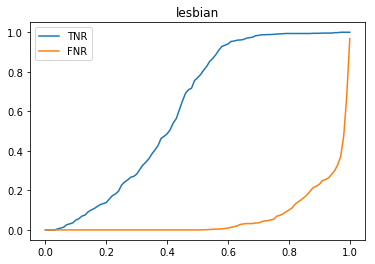

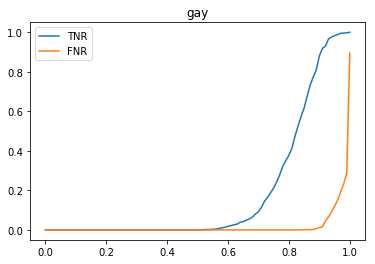

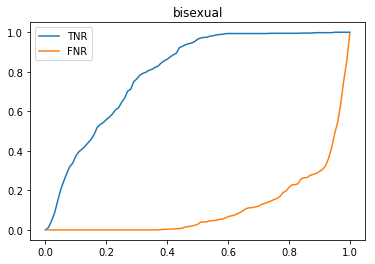

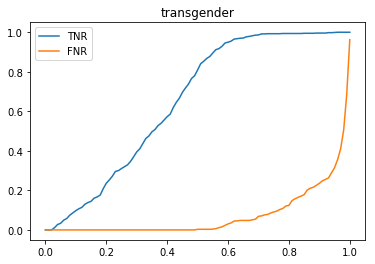

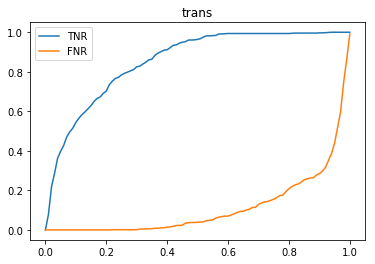

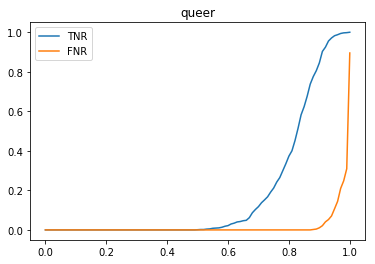

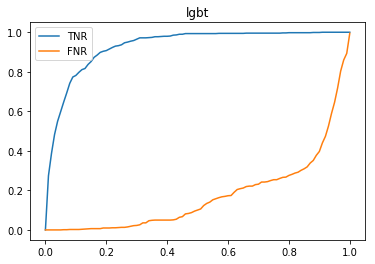

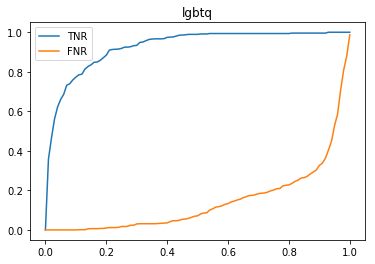

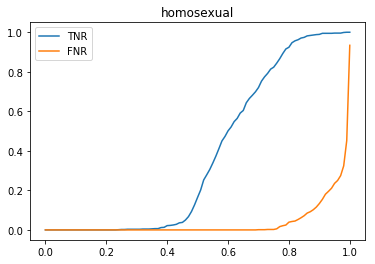

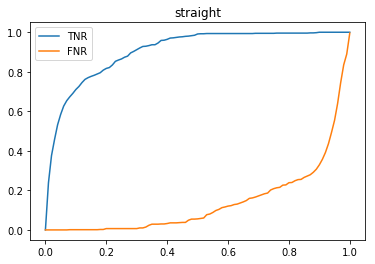

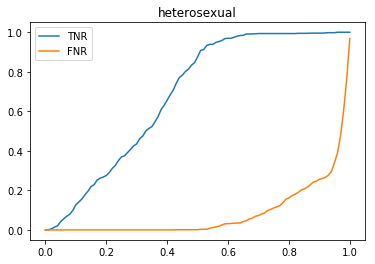

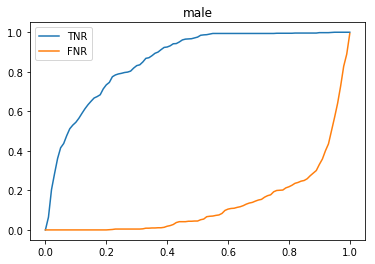

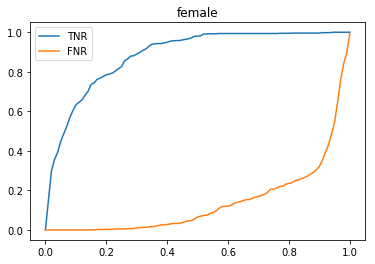

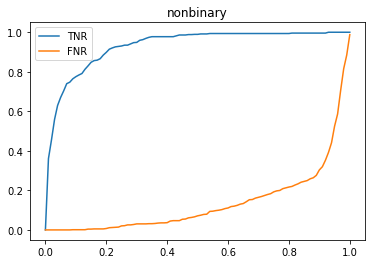

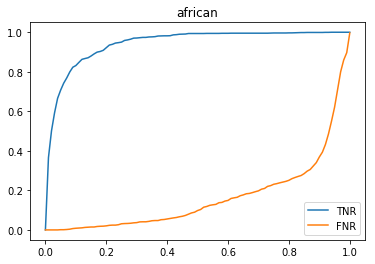

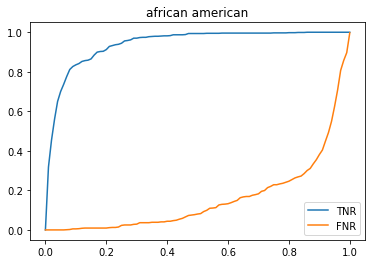

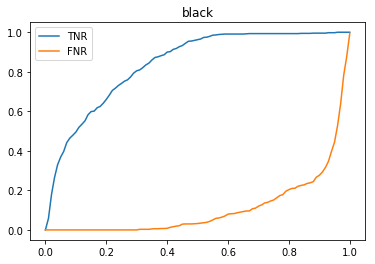

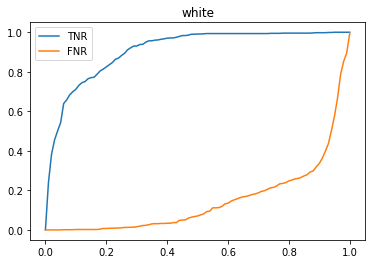

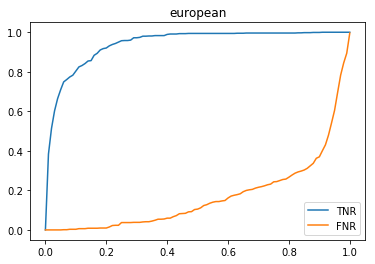

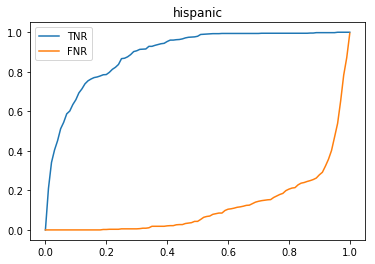

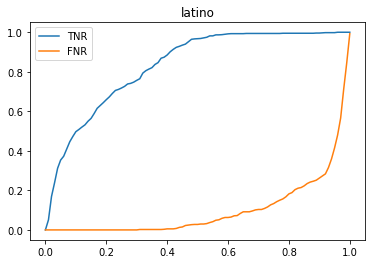

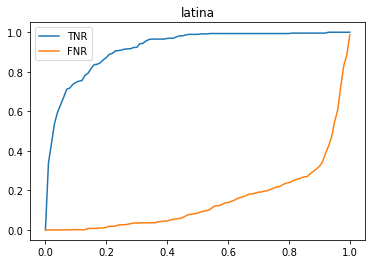

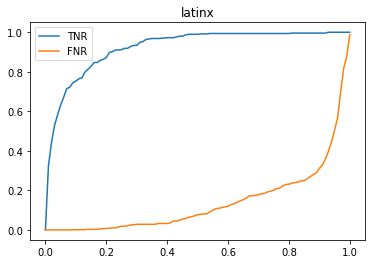

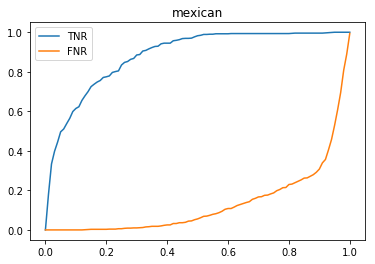

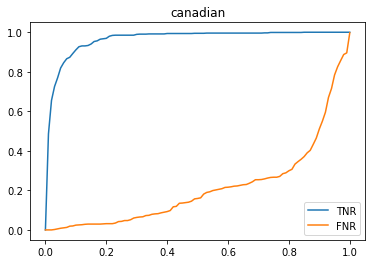

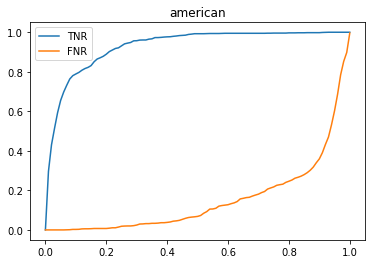

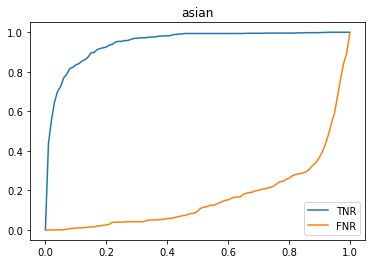

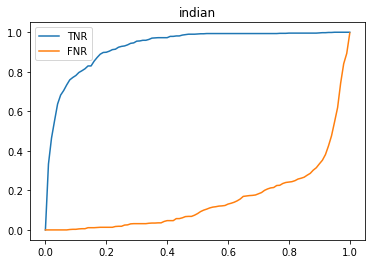

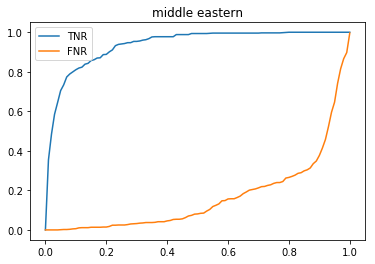

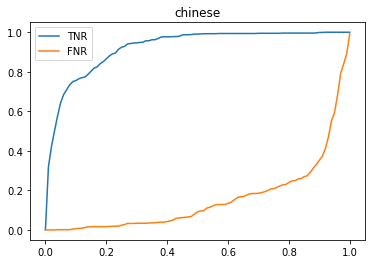

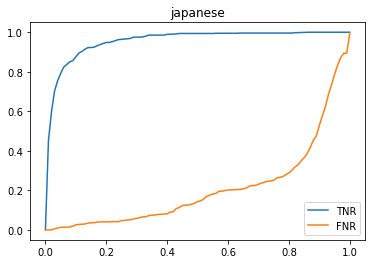

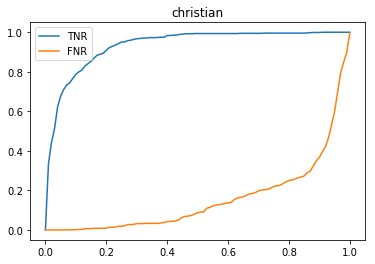

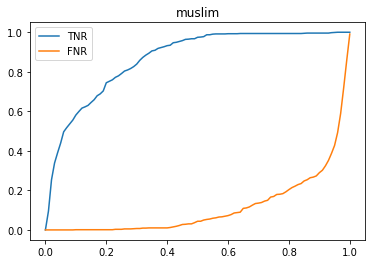

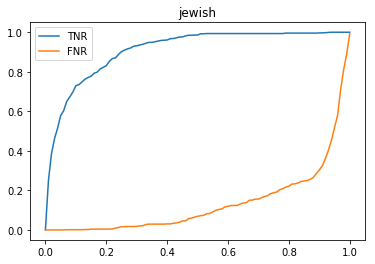

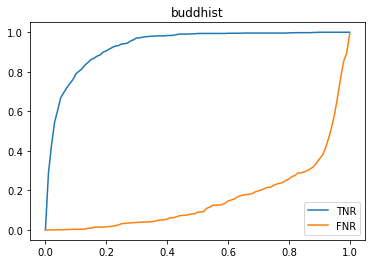

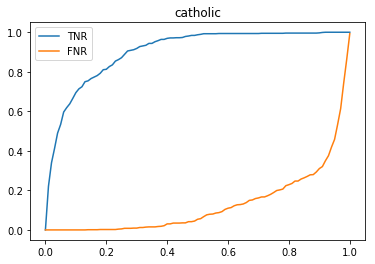

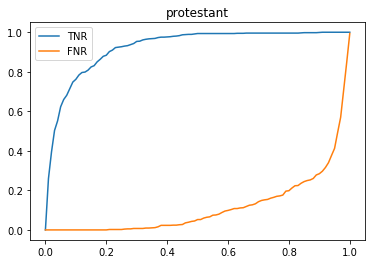

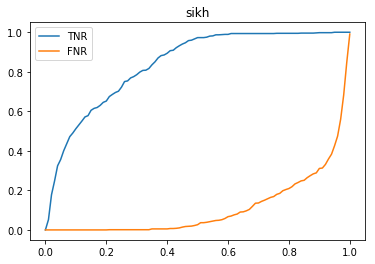

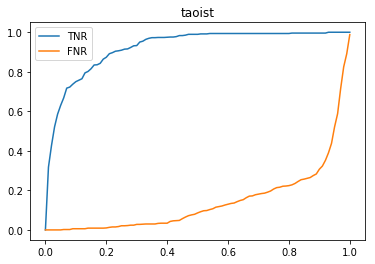

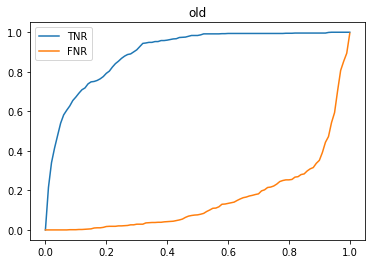

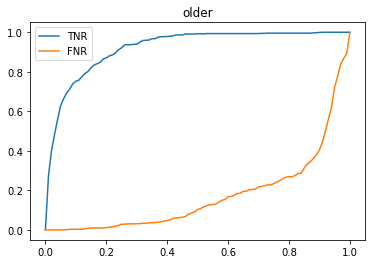

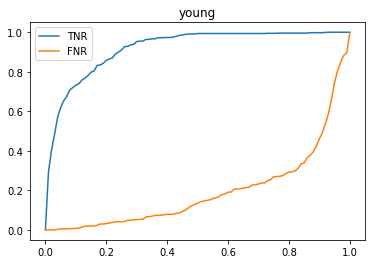

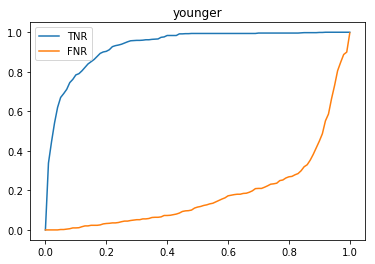

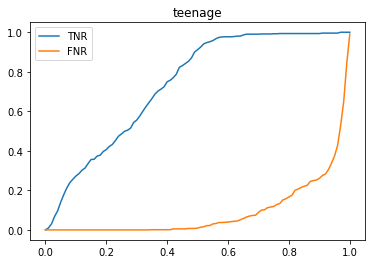

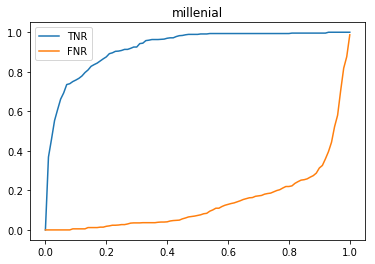

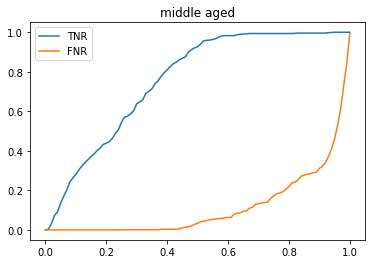

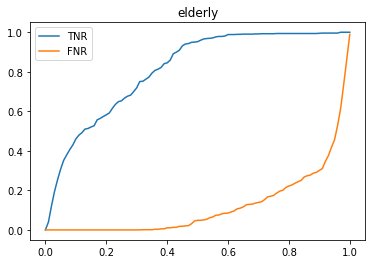

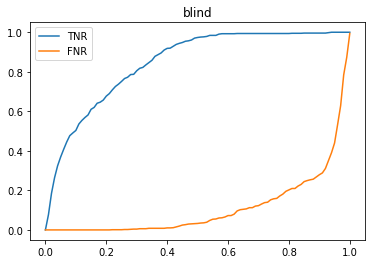

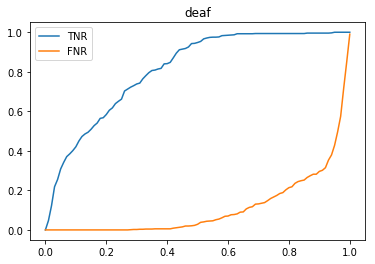

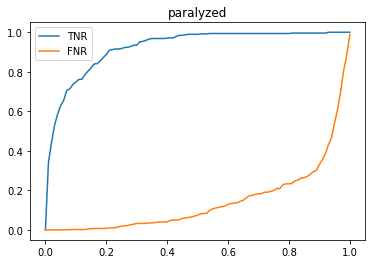

In [29]:
plot_terms_negative_rates(np.linspace(0, 1, 101))

### Equal Error Rate Threshold

In [30]:
def get_equal_error_rate(num_thresholds = 1001):
    thresholds = np.linspace(0, 1, num_thresholds)
    min_threshold = -1
    min_diff = -1
    min_confusion_matrix = -1
    for threshold in thresholds:
        confusion_matrix = confusion_matrix_counts(madlibs, 'score', 'label', threshold)
        difference = np.absolute(confusion_matrix['fn'] - confusion_matrix['fp'])
        if min_diff == -1 or difference < min_diff:
            min_threshold = threshold
            min_diff = difference
            min_confusion_matrix = confusion_matrix
    return min_threshold, min_confusion_matrix

In [31]:
%%time
get_equal_error_rate()

CPU times: user 12.9 s, sys: 109 ms, total: 13.1 s
Wall time: 13.1 s


(0.51500000000000001, {'fn': 3261, 'fp': 3254, 'tn': 41182, 'tp': 41786})